# 2.1. Preprocessing: Doublet detection and filtering

In this notebook, we start with a raw anndata object and perform some basic quality control, filter out empty droplets and remove droplets that contain more than one cell (doublets)

In [23]:
import scanpy as sc
import pandas as pd
import anndata2ri
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
plt.rcParams['figure.dpi'] = 150

First, we import some packages that we need and start up rpy2 to use R packages

In [2]:
from functools import partial
from rpy2.ipython import html
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")
import rpy2.robjects as ro
anndata2ri.activate()

In [3]:
%load_ext rpy2.ipython

Then, we load the unprocessed anndata object and convert it to a R sce object

In [4]:
adata= sc.read('/storage/groups/ml01/workspace/daniel.strobl/best_practices/mouse_intestine_raw.h5ad')

Next, we run scDblFinder to look for droplets that contain more than one cell. Other than most methods, scDblFinder works on raw counts. As scDblFinder is an R package, we use anndata2ri to convert the anndata object to a sce object and back. scDblFinder has been shown to perform very well compared to other methods (CITE pipeComp).

In [5]:
ro.globalenv['adata'] = adata

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

R[write to console]: Overclustering...



clusters
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1313  490 1472 1218  192 1416 1163  484 1128  492  764  217  861  528  840  666 
  17 
 109 


R[write to console]: Creating ~13353 artifical doublets...

R[write to console]: Identifying top genes per cluster...

R[write to console]: Building KNN graph...

R[write to console]: Evaluating cell neighborhoods...

R[write to console]: Finding threshold...

R[write to console]: Threshold found:0.464



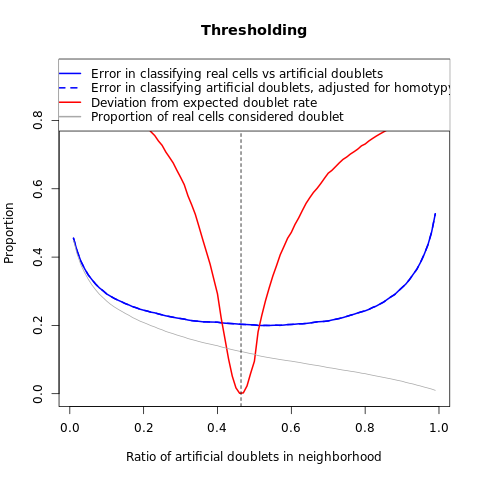

In [7]:
%%R -o adata
counts(adata) <- assay(adata, 'X')
library('scDblFinder')
adata <- scDblFinder(adata)

In [11]:
adata = ro.r('adata')

Here, scDblFinder identifies 1648 droplets as doublets. We remove those droplets from the data

In [13]:
adata.obs['scDblFinder.class'].value_counts()

singlet    11705
doublet     1648
Name: scDblFinder.class, dtype: int64

In [14]:
adata = adata[adata.obs['scDblFinder.class']=='singlet']

Now, we compute some standard qc metrics, such as the number of genes per cell `n_genes_by_counts`, number of counts per cell `total_counts`.

In [17]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

Trying to set attribute `.obs` of view, copying.


In [18]:
adata.obs

,sample,region,donor,scDblFinder.neighbors,scDblFinder.ratio,scDblFinder.score,scDblFinder.class,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACATACAGCGGA,Duo_M1,Duo,M1,9,0.111111,0.000000,singlet,1227,7.113142,12770.0,9.454932,85.082224,87.486296,90.133125,94.306969
AAACATACTTTGCT,Duo_M1,Duo,M1,6,1.000000,0.449541,singlet,1424,7.261927,2844.0,7.953319,24.015471,33.544304,45.182841,67.194093
AAACCGTGCAGTCA,Duo_M1,Duo,M1,5,0.000000,0.000000,singlet,1362,7.217443,2799.0,7.937375,27.152554,36.441586,48.481601,69.203287
AAACGCTGCGTGAT,Duo_M1,Duo,M1,5,0.200000,0.008772,singlet,1320,7.186144,2780.0,7.930566,27.697842,38.273381,50.143885,70.503597
AAACGCTGTTCACT,Duo_M1,Duo,M1,8,0.000000,0.000000,singlet,1093,6.997596,23215.0,10.052597,93.340513,94.473401,95.636442,97.445617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCAGTGACCAGT,Il_M2,Il,M2,8,0.000000,0.028571,singlet,2037,7.619724,5471.0,8.607399,23.779931,33.613599,45.256809,64.595138
TTTCGAACCAGTCA,Il_M2,Il,M2,7,0.000000,0.000000,singlet,260,5.564520,2370.0,7.771067,90.421941,93.248945,97.468354,100.000000
TTTCTACTGCTCCT,Il_M2,Il,M2,5,0.000000,0.212963,singlet,2856,7.957527,9312.0,9.139167,25.472509,33.838058,44.072165,60.728093
TTTGACTGCGCCTT,Il_M2,Il,M2,7,0.000000,0.000000,singlet,1277,7.153052,4034.0,8.302762,50.247893,56.891423,65.220625,80.738721


By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there cells with unexpected summary statistics. It is important here to look at these statistics jointly. For example, there is a cloud of points with many counts, but few genes. Our first instinct would be to filter out these as "dying" outliers, however they don't seem to show high MT fraction. We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.
Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

In [38]:
mt_gene_mask = [gene.startswith('mm10_mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

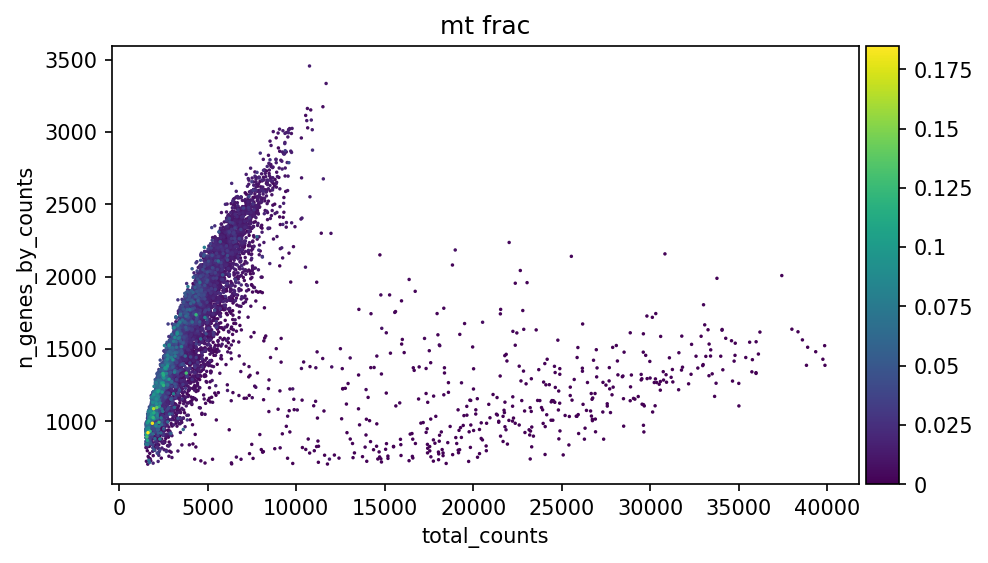

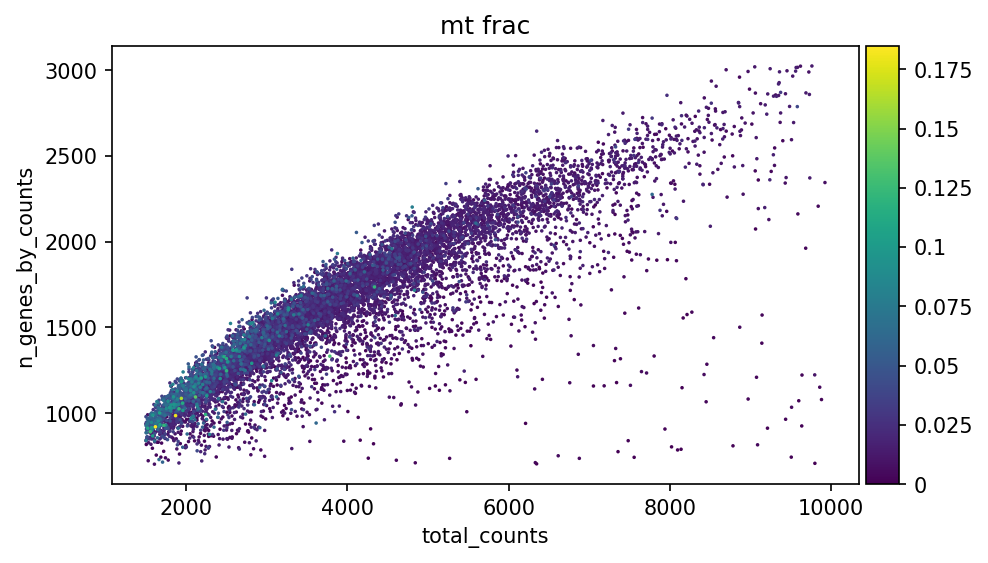

In [39]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<10000], 'total_counts', 'n_genes_by_counts', color='mt_frac')

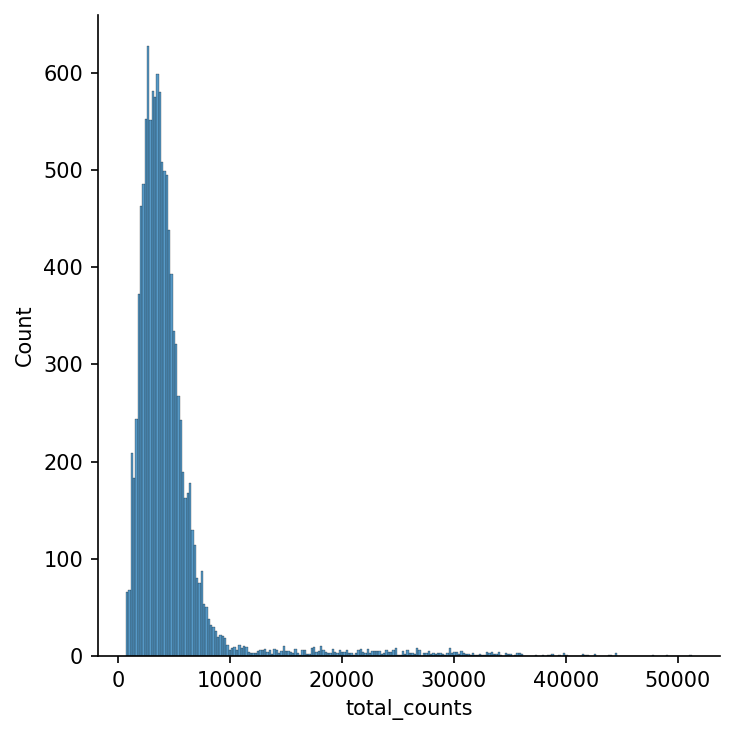

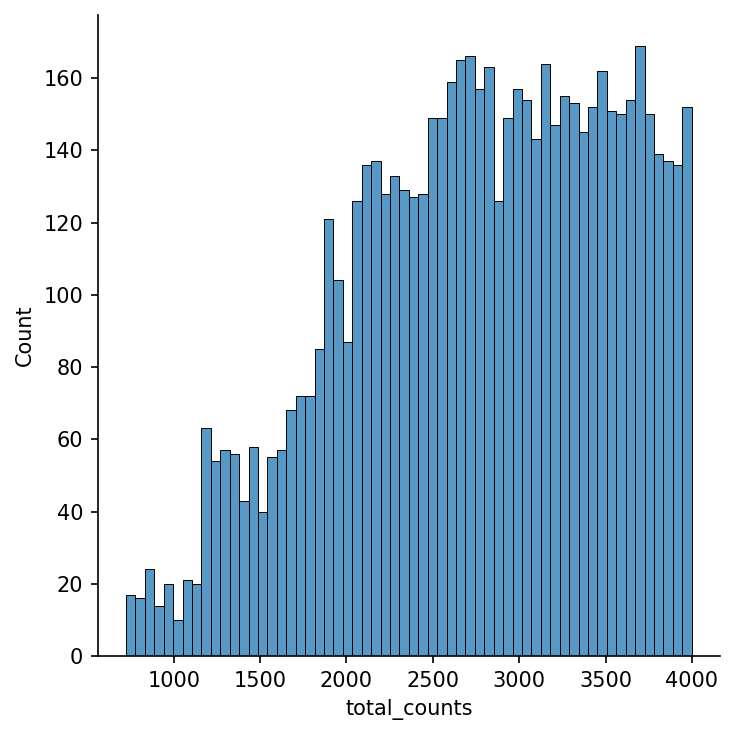

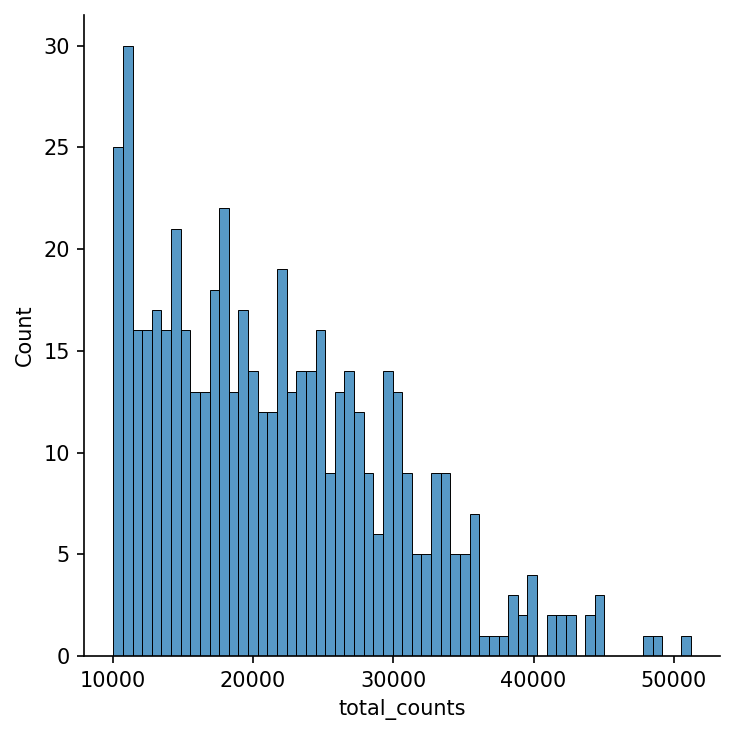

In [30]:
#Thresholding decision: counts
p3 = sns.displot(adata.obs['total_counts'])
plt.show()

p4 = sns.displot(adata.obs['total_counts'][adata.obs['total_counts']<4000], bins=60)
plt.show()

p5 = sns.displot(adata.obs['total_counts'][adata.obs['total_counts']>10000], bins=60)
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.
In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

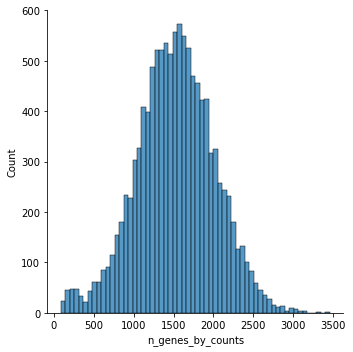

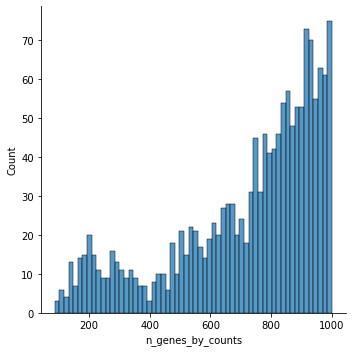

In [25]:
#Thresholding decision: genes
p6 = sns.displot(adata.obs['n_genes_by_counts'], bins=60)
plt.show()

p7 = sns.displot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1000], bins=60)
plt.show()

In [32]:
#Filter cells:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 11211
Number of cells after min count filter: 11211
Number of cells after max count filter: 11211
Number of cells after gene filter: 10810


In [33]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
Number of genes after cell filter: 12573
